In [1]:
import pymesh

In [2]:
import numpy as np
import sys
sys.path.append("../../../source/")

In [3]:
ground_truth_dir = 'ground_truth/'
masif_pred_dir = 'masif_pred/'
transient_interactions_file = 'testing_transient.txt'

# List of atonn_predictions
atonn_pred_dir = '../pdbs_benchmark/'

# List of sppider_predictions
sppider_pred_dir = 'sppider_pred/'

# List of intpred_predictions
intpred_pred_dir = 'intpred_pred/intpred_pdbs/'

# List of psiver_predictions
psiver_pred_dir = 'psiver_pred/psiver_pdbs/'

In [4]:
# The list that we will use has 53 proteins which are the ones that worked on both SPPIDER and IntPred.
transient_pdbs = set([''.join(x[0:4]) for x in open(transient_interactions_file).readlines()])

In [5]:
# To follow SPPIDER's implementation  we only label as interface those residues 
# with points with more than 4% RSA change and at least 5A RSA change.
def is_res_iface(res_labels, vertex_areas):
    sum_iface_area = 0.0
    sum_total_res_area = 0.0

    for ix, label in enumerate(res_labels): 
        sum_total_res_area += vertex_areas[ix]
        if label > 0:
            sum_iface_area += vertex_areas[ix]

    if sum_iface_area > 5.0 and sum_iface_area/sum_total_res_area > 0.04:
        return True
    else:
        return False

In [6]:
# Get the ground truth per residue (as we have it per surface point.)
# Atoms: list of PDB atoms in Biopython format. 
# Residues: list of PDB residues in Biopython format. 
# ground_truth_mesh: a pymesh mesh object with labeled interface (the ground truth.)
# Returns a dict where the key is the residue id and the value is the score. 
def assign_labels_per_residue(atoms, residues, ground_truth_mesh):
    # For every residue, assign a label on whether it is interface or not, based on the buried surface.
    flann = pyflann.FLANN()
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    verts = ground_truth_mesh.vertices.astype(float)

    labels = ground_truth_mesh.get_attribute('vertex_iface')
    ground_truth_mesh.add_attribute("vertex_area")
    vertex_areas = ground_truth_mesh.get_attribute("vertex_area")

    # Compute the closest atom to each vertex. 
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n= len(r)
    
    # For each residue, assign the ground truth based on the closest atom. 
    res_labels = {}
    res_areas = {}
    for ix, v in enumerate(verts): 
        pred = labels[ix]
        res_id = atoms[r[ix]].get_parent().get_id()
        if res_id not in res_labels:
            res_labels[res_id] = []
            res_areas[res_id] = []
        res_labels[res_id].append(pred)
        res_areas[res_id].append(vertex_areas[ix])
    res_labels_tmp = []
    for key in res_labels:
        # To follow SPPIDER's implementation (as an approximation) we only label as interface those residues 
        # with points with more than 4% RSA change and at least 5A RSA change.
        if is_res_iface(res_labels[key], res_areas[key]):
            res_labels[key] = 1.0
        else:
            res_labels[key] = 0.0
            
    return res_labels

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# Compute the score of each predicted surface. 
from IPython.core.debugger import set_trace
from Bio.PDB import *
import pyflann
import sklearn.metrics
import os

# Compute the ROC AUC for SPPIDER/INTPRED for points and residues. 
# SPPIDER/INTPRED work on residues while we work on points. 
# This method computes ROC AUCs according to both. 
def compute_roc_auc_sppider_intpred_psiver(pred_dir, pdbid, alpha=1e-2):
    parser = PDBParser()
    struct = parser.get_structure(pred_dir+pdbid+'.pdb', pred_dir+pdbid+'.pdb')
    atoms = Selection.unfold_entities(struct, 'A')
    residues = Selection.unfold_entities(struct, 'R')
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    
    ground_truth_mesh = pymesh.load_mesh(ground_truth_dir+pdbid+'.ply')


    flann = pyflann.FLANN()
    
    verts = ground_truth_mesh.vertices.astype(float)
    
    # Compute the closest atom to each vertex in vertices
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n= len(r)
    
    # For each vertex, assign the predictions according to the closest atoms.
    pred = np.zeros((n))
    labels = ground_truth_mesh.get_attribute('vertex_iface')
    
    labels_per_residue = assign_labels_per_residue(atoms, residues, ground_truth_mesh)
    
    res_pred = {}
    for res in residues:
        if 'CA' in res:
            bfactor = res['CA'].bfactor
            # If the bfactor is less than zero it means that it was ignored by the program (by intpred in this case.)
            if bfactor >= 0:
                res_pred[res.get_id()] = bfactor * alpha

    res_pred_y = []
    res_label_y = []
    for key in labels_per_residue:
        if key in res_pred and key in labels_per_residue:
            res_pred_y.append(res_pred[key])
            res_label_y.append(labels_per_residue[key])

    try:
        res_roc_auc = sklearn.metrics.roc_auc_score(res_label_y, res_pred_y)
    except:
        res_roc_auc = 0.5
    print('Per residue ROC AUC: {:.2f}'.format(res_roc_auc))
    
    for vi in range(n):
        pred[vi] = atoms[r[vi]].bfactor * alpha
        
    roc_auc = sklearn.metrics.roc_auc_score(labels, pred)
    print('{} Per point ROC AUC {} : {:.2f}'.format(pred_dir, pdbid, roc_auc))
    return labels, pred, res_label_y, res_pred_y, roc_auc, res_roc_auc

/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4112
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4113
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3786
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3787
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5338
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.45
intpred_pred/intpred_pdbs/ Per point ROC AUC 1XQS_A : 0.43
Per residue ROC AUC: 0.52
intpred_pred/intpred_pdbs/ Per point ROC AUC 1JTD_B : 0.44
Per residue ROC AUC: 0.72
intpred_pred/intpred_pdbs/ Per point ROC AUC 5TIH_A : 0.57


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3786
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3787
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5282
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5283
  PDBConstructionWarning,


Per residue ROC AUC: 0.41
intpred_pred/intpred_pdbs/ Per point ROC AUC 4XL5_C : 0.52
Per residue ROC AUC: 0.40
intpred_pred/intpred_pdbs/ Per point ROC AUC 3ZWL_B : 0.38


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5473
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5474
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6055
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6056
  PDBConstructionWarning,


Per residue ROC AUC: 0.48
intpred_pred/intpred_pdbs/ Per point ROC AUC 3MCA_B : 0.57
Per residue ROC AUC: 0.37
intpred_pred/intpred_pdbs/ Per point ROC AUC 3NVN_A : 0.58


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5915
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5916
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5282
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5283
  PDBConstructionWarning,


Per residue ROC AUC: 0.84
intpred_pred/intpred_pdbs/ Per point ROC AUC 4ZGY_A : 0.80
Per residue ROC AUC: 0.55
intpred_pred/intpred_pdbs/ Per point ROC AUC 1W1W_B : 0.49


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6030
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6031
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4544
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4545
  PDBConstructionWarning,


Per residue ROC AUC: 0.82
intpred_pred/intpred_pdbs/ Per point ROC AUC 4ETP_A : 0.79
Per residue ROC AUC: 0.42
intpred_pred/intpred_pdbs/ Per point ROC AUC 2C0L_A : 0.39


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4946
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4947
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5628
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5629
  PDBConstructionWarning,


Per residue ROC AUC: 0.35
intpred_pred/intpred_pdbs/ Per point ROC AUC 4M0W_A : 0.37
Per residue ROC AUC: 0.52
intpred_pred/intpred_pdbs/ Per point ROC AUC 2QXV_A : 0.41


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5987
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5988
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4841
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4842
  PDBConstructionWarning,


Per residue ROC AUC: 0.59
intpred_pred/intpred_pdbs/ Per point ROC AUC 1WDW_H : 0.55
Per residue ROC AUC: 0.60
intpred_pred/intpred_pdbs/ Per point ROC AUC 4YC7_B : 0.51


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5747
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5748
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4584
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4585
  PDBConstructionWarning,


Per residue ROC AUC: 0.43
intpred_pred/intpred_pdbs/ Per point ROC AUC 3VYR_B : 0.46
Per residue ROC AUC: 0.39
intpred_pred/intpred_pdbs/ Per point ROC AUC 3VV2_A : 0.34


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4495
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4496
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4483
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4484
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5478
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.68
intpred_pred/intpred_pdbs/ Per point ROC AUC 3O5T_A : 0.58
Per residue ROC AUC: 0.58
intpred_pred/intpred_pdbs/ Per point ROC AUC 4C9B_B : 0.59
Per residue ROC AUC: 0.52
intpred_pred/intpred_pdbs/ Per point ROC AUC 1ZHH_A : 0.49


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3686
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3687
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5128
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5129
  PDBConstructionWarning,


Per residue ROC AUC: 0.59
intpred_pred/intpred_pdbs/ Per point ROC AUC 2XWT_C : 0.51
Per residue ROC AUC: 0.45
intpred_pred/intpred_pdbs/ Per point ROC AUC 2PMS_A : 0.40


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4290
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4291
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5952
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5953
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3323
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.74
intpred_pred/intpred_pdbs/ Per point ROC AUC 3WN7_A : 0.56
Per residue ROC AUC: 0.65
intpred_pred/intpred_pdbs/ Per point ROC AUC 3FHC_A : 0.58
Per residue ROC AUC: 0.28
intpred_pred/intpred_pdbs/ Per point ROC AUC 2V9T_B : 0.29


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4850
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4851
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4710
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4711
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4384
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.65
intpred_pred/intpred_pdbs/ Per point ROC AUC 4ZRJ_A : 0.53
Per residue ROC AUC: 0.81
intpred_pred/intpred_pdbs/ Per point ROC AUC 4ETP_B : 0.84
Per residue ROC AUC: 0.47
intpred_pred/intpred_pdbs/ Per point ROC AUC 4V0O_F : 0.52


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4856
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4857
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5144
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5145
  PDBConstructionWarning,


Per residue ROC AUC: 0.91
intpred_pred/intpred_pdbs/ Per point ROC AUC 2F4M_A : 0.83
Per residue ROC AUC: 0.46
intpred_pred/intpred_pdbs/ Per point ROC AUC 2WUS_A : 0.49


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5698
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5699
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5132
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5133
  PDBConstructionWarning,


Per residue ROC AUC: 0.64
intpred_pred/intpred_pdbs/ Per point ROC AUC 2V3B_A : 0.55
Per residue ROC AUC: 0.56
intpred_pred/intpred_pdbs/ Per point ROC AUC 4HDO_A : 0.57


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4885
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4886
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5287
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5288
  PDBConstructionWarning,


Per residue ROC AUC: 0.49
intpred_pred/intpred_pdbs/ Per point ROC AUC 3BH6_B : 0.45
Per residue ROC AUC: 0.46
intpred_pred/intpred_pdbs/ Per point ROC AUC 2I3T_A : 0.56


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5814
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5815
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5581
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5582
  PDBConstructionWarning,


Per residue ROC AUC: 0.49
intpred_pred/intpred_pdbs/ Per point ROC AUC 4BKX_B : 0.47
Per residue ROC AUC: 0.43
intpred_pred/intpred_pdbs/ Per point ROC AUC 2AYO_A : 0.35


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4830
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4831
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3806
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3807
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4146
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.35
intpred_pred/intpred_pdbs/ Per point ROC AUC 1XG2_A : 0.40
Per residue ROC AUC: 0.42
intpred_pred/intpred_pdbs/ Per point ROC AUC 4Y61_B : 0.39
Per residue ROC AUC: 0.62
intpred_pred/intpred_pdbs/ Per point ROC AUC 5J57_A : 0.62


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4913
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4914
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5286
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5287
  PDBConstructionWarning,


Per residue ROC AUC: 0.43
intpred_pred/intpred_pdbs/ Per point ROC AUC 4X33_B : 0.33
Per residue ROC AUC: 0.26
intpred_pred/intpred_pdbs/ Per point ROC AUC 3SJA_I : 0.44


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4492
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4493
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5754
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5755
  PDBConstructionWarning,


Per residue ROC AUC: 0.60
intpred_pred/intpred_pdbs/ Per point ROC AUC 3QML_D : 0.56
Per residue ROC AUC: 0.38
intpred_pred/intpred_pdbs/ Per point ROC AUC 1I2M_B : 0.40


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6084
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6085
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4753
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4754
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4755
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.47
intpred_pred/intpred_pdbs/ Per point ROC AUC 3H6G_B : 0.47
Per residue ROC AUC: 0.26
intpred_pred/intpred_pdbs/ Per point ROC AUC 1EWY_A : 0.30
Per residue ROC AUC: 0.41
intpred_pred/intpred_pdbs/ Per point ROC AUC 4DVG_B : 0.41


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4224
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4225
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4816
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4817
  PDBConstructionWarning,


Per residue ROC AUC: 0.45
intpred_pred/intpred_pdbs/ Per point ROC AUC 4YEB_A : 0.47
Per residue ROC AUC: 0.60
intpred_pred/intpred_pdbs/ Per point ROC AUC 1F6M_A : 0.51


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5207
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5208
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5101
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5102
  PDBConstructionWarning,


Per residue ROC AUC: 0.46
intpred_pred/intpred_pdbs/ Per point ROC AUC 4LVN_A : 0.48
Per residue ROC AUC: 0.57
intpred_pred/intpred_pdbs/ Per point ROC AUC 3RT0_A : 0.57
Number of proteins: 50
IntPred Global ROC AUC: 0.5049
IntPred Global ROC AUC per residue: 0.5367
IntPred Median ROC AUC per protein : 0.4939
IntPred Median ROC AUC per residue per protein: 0.4810


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifi

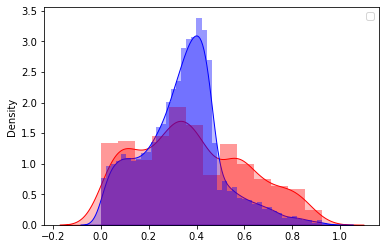

In [8]:
# Benchmark IntPred
   
all_pred = []
all_labels = []

all_pred_res = []
all_labels_res = []

all_roc_auc_per_prot_intpred = []
all_res_roc_auc_per_prot_intpred = []

for fn in os.listdir(intpred_pred_dir):  
    
    pdbid_chain = fn.split('.')[0]
    pdbid = pdbid_chain.split('_')[0]
    if pdbid not in transient_pdbs: 
        continue

    l, p, res_l, res_p, roc_auc, res_roc_auc = compute_roc_auc_sppider_intpred_psiver(intpred_pred_dir, pdbid_chain)

    all_pred.append(p)
    all_labels.append(l)
    
    all_pred_res.append(res_p)
    all_labels_res.append(res_l)
    
    all_roc_auc_per_prot_intpred.append(roc_auc)
    all_res_roc_auc_per_prot_intpred.append(res_roc_auc)
    
print("Number of proteins: {}".format(len(all_pred)))

all_pred = np.concatenate(all_pred, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

all_pred_by_point_intpred = all_pred.copy()
all_labels_by_point_intpred = all_labels.copy()

#print(metrics.roc_auc_score(all_my_labels_per_res, all_my_pred_per_res))

all_labels_res = np.concatenate(all_labels_res, axis=0)

all_pred_res = np.concatenate(all_pred_res, axis=0)


all_roc_auc = sklearn.metrics.roc_auc_score(all_labels, all_pred)
all_roc_auc_res = sklearn.metrics.roc_auc_score(all_labels_res, all_pred_res)



print('IntPred Global ROC AUC: {:.4f}'.format(all_roc_auc))
print('IntPred Global ROC AUC per residue: {:.4f}'.format(all_roc_auc_res))

print('IntPred Median ROC AUC per protein : {:.4f}'.format(np.median(all_roc_auc_per_prot_intpred)))
print('IntPred Median ROC AUC per residue per protein: {:.4f}'.format(np.median(all_res_roc_auc_per_prot_intpred)))

pos_label = np.where(all_labels_res == 1)[0]
pos = all_pred_res[pos_label]
neg_label = np.where(all_labels_res == 0)[0]
neg = all_pred_res[neg_label]
sns.distplot(pos, hist=True, color='r', kde_kws={"shade": True}, norm_hist=True, label='true positives')
sns.distplot(neg, hist=True, color='b', kde_kws={"shade": True}, norm_hist=True, label='true negatives')
plt.legend('true positives', 'true negatives')

/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4112
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4113
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3786
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3787
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5338
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.81
psiver_pred/psiver_pdbs/ Per point ROC AUC 1XQS_A : 0.81
Per residue ROC AUC: 0.91
psiver_pred/psiver_pdbs/ Per point ROC AUC 1JTD_B : 0.83
Per residue ROC AUC: 0.33
psiver_pred/psiver_pdbs/ Per point ROC AUC 5TIH_A : 0.32


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3786
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3787
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5282
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5283
  PDBConstructionWarning,


Per residue ROC AUC: 0.76
psiver_pred/psiver_pdbs/ Per point ROC AUC 4XL5_C : 0.73
Per residue ROC AUC: 0.49
psiver_pred/psiver_pdbs/ Per point ROC AUC 3ZWL_B : 0.49


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5473
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5474
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6055
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6056
  PDBConstructionWarning,


Per residue ROC AUC: 0.66
psiver_pred/psiver_pdbs/ Per point ROC AUC 3MCA_B : 0.57
Per residue ROC AUC: 0.65
psiver_pred/psiver_pdbs/ Per point ROC AUC 3NVN_A : 0.55


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5915
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5916
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5282
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5283
  PDBConstructionWarning,


Per residue ROC AUC: 0.66
psiver_pred/psiver_pdbs/ Per point ROC AUC 4ZGY_A : 0.57
Per residue ROC AUC: 0.51
psiver_pred/psiver_pdbs/ Per point ROC AUC 1W1W_B : 0.44


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6030
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6031
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4544
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4545
  PDBConstructionWarning,


Per residue ROC AUC: 0.41
psiver_pred/psiver_pdbs/ Per point ROC AUC 4ETP_A : 0.35
Per residue ROC AUC: 0.68
psiver_pred/psiver_pdbs/ Per point ROC AUC 2C0L_A : 0.63
Per residue ROC AUC: 0.60


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4946
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4947
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5628
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5629
  PDBConstructionWarning,


psiver_pred/psiver_pdbs/ Per point ROC AUC 4M0W_A : 0.61
Per residue ROC AUC: 0.50
psiver_pred/psiver_pdbs/ Per point ROC AUC 2QXV_A : 0.54


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5987
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5988
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4841
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4842
  PDBConstructionWarning,


Per residue ROC AUC: 0.52
psiver_pred/psiver_pdbs/ Per point ROC AUC 1WDW_H : 0.50
Per residue ROC AUC: 0.57
psiver_pred/psiver_pdbs/ Per point ROC AUC 4YC7_B : 0.54


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5747
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5748
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4584
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4585
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4495
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.58
psiver_pred/psiver_pdbs/ Per point ROC AUC 3VYR_B : 0.56
Per residue ROC AUC: 0.50
psiver_pred/psiver_pdbs/ Per point ROC AUC 3VV2_A : 0.54
Per residue ROC AUC: 0.62
psiver_pred/psiver_pdbs/ Per point ROC AUC 3O5T_A : 0.53


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4483
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4484
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5478
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5479
  PDBConstructionWarning,


Per residue ROC AUC: 0.70
psiver_pred/psiver_pdbs/ Per point ROC AUC 4C9B_B : 0.67
Per residue ROC AUC: 0.65
psiver_pred/psiver_pdbs/ Per point ROC AUC 1ZHH_A : 0.54


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3686
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3687
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5128
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5129
  PDBConstructionWarning,


Per residue ROC AUC: 0.55
psiver_pred/psiver_pdbs/ Per point ROC AUC 2XWT_C : 0.56
Per residue ROC AUC: 0.45
psiver_pred/psiver_pdbs/ Per point ROC AUC 2PMS_A : 0.47
Per residue ROC AUC: 0.69
psiver_pred/psiver_pdbs/ Per point ROC AUC 3WN7_A : 0.69
Per residue ROC AUC: 0.32
psiver_pred/psiver_pdbs/ Per point ROC AUC 1NCA_N : 0.38


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4290
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4291
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5986
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5987
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5952
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.62
psiver_pred/psiver_pdbs/ Per point ROC AUC 3FHC_A : 0.67
Per residue ROC AUC: 0.52
psiver_pred/psiver_pdbs/ Per point ROC AUC 2V9T_B : 0.57
Per residue ROC AUC: 0.44
psiver_pred/psiver_pdbs/ Per point ROC AUC 4ZRJ_A : 0.45


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3323
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3324
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4850
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4851
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4710
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.46
psiver_pred/psiver_pdbs/ Per point ROC AUC 4ETP_B : 0.39
Per residue ROC AUC: 0.53
psiver_pred/psiver_pdbs/ Per point ROC AUC 4V0O_F : 0.52


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4384
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4385
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4856
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4857
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5144
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.50
psiver_pred/psiver_pdbs/ Per point ROC AUC 2F4M_A : 0.56
Per residue ROC AUC: 0.66
psiver_pred/psiver_pdbs/ Per point ROC AUC 2WUS_A : 0.61


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5698
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5699
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5132
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5133
  PDBConstructionWarning,


Per residue ROC AUC: 0.46
psiver_pred/psiver_pdbs/ Per point ROC AUC 2V3B_A : 0.41
Per residue ROC AUC: 0.76
psiver_pred/psiver_pdbs/ Per point ROC AUC 4HDO_A : 0.70
Per residue ROC AUC: 0.79
psiver_pred/psiver_pdbs/ Per point ROC AUC 3BH6_B : 0.81


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4885
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4886
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5287
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5288
  PDBConstructionWarning,


Per residue ROC AUC: 0.41
psiver_pred/psiver_pdbs/ Per point ROC AUC 2I3T_A : 0.40
Per residue ROC AUC: 0.61
psiver_pred/psiver_pdbs/ Per point ROC AUC 4BKX_B : 0.58


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5814
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5815
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5581
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5582
  PDBConstructionWarning,


Per residue ROC AUC: 0.64
psiver_pred/psiver_pdbs/ Per point ROC AUC 2AYO_A : 0.63
Per residue ROC AUC: 0.77
psiver_pred/psiver_pdbs/ Per point ROC AUC 1XG2_A : 0.75
Per residue ROC AUC: 0.69
psiver_pred/psiver_pdbs/ Per point ROC AUC 4Y61_B : 0.68


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4830
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4831
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3806
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3807
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4146
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.54
psiver_pred/psiver_pdbs/ Per point ROC AUC 5J57_A : 0.49
Per residue ROC AUC: 0.54
psiver_pred/psiver_pdbs/ Per point ROC AUC 4X33_B : 0.41
Per residue ROC AUC: 0.84
psiver_pred/psiver_pdbs/ Per point ROC AUC 3SJA_I : 0.78
Per residue ROC AUC: 0.77
psiver_pred/psiver_pdbs/ Per point ROC AUC 3QML_D : 0.83


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4492
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4493
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5754
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5755
  PDBConstructionWarning,


Per residue ROC AUC: 0.76
psiver_pred/psiver_pdbs/ Per point ROC AUC 1I2M_B : 0.71
Per residue ROC AUC: 0.46
psiver_pred/psiver_pdbs/ Per point ROC AUC 3H6G_B : 0.39


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6084
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6085
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4753
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4754
  PDBConstructionWarning,


Per residue ROC AUC: 0.69
psiver_pred/psiver_pdbs/ Per point ROC AUC 1EWY_A : 0.68
Per residue ROC AUC: 0.62
psiver_pred/psiver_pdbs/ Per point ROC AUC 4DVG_B : 0.62


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4755
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4756
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4224
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4225
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4816
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.54
psiver_pred/psiver_pdbs/ Per point ROC AUC 4YEB_A : 0.55
Per residue ROC AUC: 0.64
psiver_pred/psiver_pdbs/ Per point ROC AUC 1F6M_A : 0.56
Per residue ROC AUC: 0.45
psiver_pred/psiver_pdbs/ Per point ROC AUC 4LVN_A : 0.44


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5207
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5208
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5101
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5102
  PDBConstructionWarning,


Per residue ROC AUC: 0.71
psiver_pred/psiver_pdbs/ Per point ROC AUC 3RT0_A : 0.61
Number of proteins: 51
psiver Global ROC AUC: 0.58
psiver Global ROC AUC per residue: 0.60
psiver Median ROC AUC per protein : 0.56
psiver Median ROC AUC per residue per protein: 0.61


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

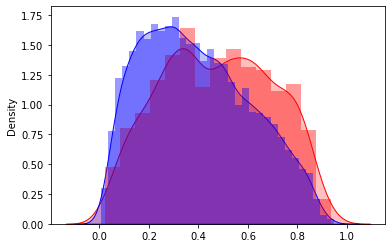

In [9]:
# Benchmark PSIVER
   
all_pred = []
all_labels = []

all_pred_res = []
all_labels_res = []

all_roc_auc_per_prot_psiver = []
all_res_roc_auc_per_prot_psiver = []

for fn in os.listdir(psiver_pred_dir):  
    
    pdbid_chain = fn.split('.')[0]
    pdbid = pdbid_chain.split('_')[0]
    if pdbid not in transient_pdbs: 
        continue

    l, p, res_l, res_p, roc_auc, res_roc_auc = compute_roc_auc_sppider_intpred_psiver(psiver_pred_dir, pdbid_chain)

    all_pred.append(p)
    all_labels.append(l)
    
    all_pred_res.append(res_p)
    all_labels_res.append(res_l)
    
    all_roc_auc_per_prot_psiver.append(roc_auc)
    all_res_roc_auc_per_prot_psiver.append(res_roc_auc)
    
print("Number of proteins: {}".format(len(all_pred)))

all_pred = np.concatenate(all_pred, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

all_pred_by_point_psiver = all_pred.copy()
all_labels_by_point_psiver = all_labels.copy()

#print(metrics.roc_auc_score(all_my_labels_per_res, all_my_pred_per_res))

all_labels_res = np.concatenate(all_labels_res, axis=0)

all_pred_res = np.concatenate(all_pred_res, axis=0)


all_roc_auc = sklearn.metrics.roc_auc_score(all_labels, all_pred)
all_roc_auc_res = sklearn.metrics.roc_auc_score(all_labels_res, all_pred_res)



print('psiver Global ROC AUC: {:.2f}'.format(all_roc_auc))
print('psiver Global ROC AUC per residue: {:.2f}'.format(all_roc_auc_res))

print('psiver Median ROC AUC per protein : {:.2f}'.format(np.median(all_roc_auc_per_prot_psiver)))
print('psiver Median ROC AUC per residue per protein: {:.2f}'.format(np.median(all_res_roc_auc_per_prot_psiver)))

pos_label = np.where(all_labels_res == 1)[0]
pos = all_pred_res[pos_label]
neg_label = np.where(all_labels_res == 0)[0]
neg = all_pred_res[neg_label]
sns.distplot(pos, hist=True, color='r', kde_kws={"shade": True}, norm_hist=True)
sns.distplot(neg, hist=True, color='b', kde_kws={"shade": True}, norm_hist=True)

1XQS
Per residue ROC AUC: 0.57
sppider_pred/ Per point ROC AUC 1XQS_A : 0.52
1JTD
Per residue ROC AUC: 0.76
sppider_pred/ Per point ROC AUC 1JTD_B : 0.70
1GP2
5TIH


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4115
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4116
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3794
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3795
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5341
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.39
sppider_pred/ Per point ROC AUC 5TIH_A : 0.30
4XL5
Per residue ROC AUC: 0.74
sppider_pred/ Per point ROC AUC 4XL5_C : 0.75
3ZWL


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3796
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3797
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5280
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5281
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5474
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.64
sppider_pred/ Per point ROC AUC 3ZWL_B : 0.55
3MCA
Per residue ROC AUC: 0.72
sppider_pred/ Per point ROC AUC 3MCA_B : 0.73
3NVN


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6061
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6062
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5923
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5924
  PDBConstructionWarning,


Per residue ROC AUC: 0.65
sppider_pred/ Per point ROC AUC 3NVN_A : 0.68
2OOR
4ZGY
Per residue ROC AUC: 0.83
sppider_pred/ Per point ROC AUC 4ZGY_A : 0.82
1W1W


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5291
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5292
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6030
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6031
  PDBConstructionWarning,


Per residue ROC AUC: 0.82
sppider_pred/ Per point ROC AUC 1W1W_B : 0.81
3LVK
4ETP
Per residue ROC AUC: 0.85
sppider_pred/ Per point ROC AUC 4ETP_A : 0.86
2C0L


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4550
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4551
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4950
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4951
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5624
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.49
sppider_pred/ Per point ROC AUC 2C0L_A : 0.48
4M0W
Per residue ROC AUC: 0.66
sppider_pred/ Per point ROC AUC 4M0W_A : 0.58
2QXV
Per residue ROC AUC: 0.57
sppider_pred/ Per point ROC AUC 2QXV_A : 0.51
1WDW
Per residue ROC AUC: 0.88
sppider_pred/ Per point ROC AUC 1WDW_H : 0.82
4YC7


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5990
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5991
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4842
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4843
  PDBConstructionWarning,


Per residue ROC AUC: 0.65
sppider_pred/ Per point ROC AUC 4YC7_B : 0.64
3VYR
Per residue ROC AUC: 0.80
sppider_pred/ Per point ROC AUC 3VYR_B : 0.74
2MTA
3VV2
Per residue ROC AUC: 0.64
sppider_pred/ Per point ROC AUC 3VV2_A : 0.68
3O5T


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5755
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5756
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4592
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4593
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4494
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.86
sppider_pred/ Per point ROC AUC 3O5T_A : 0.86
4C9B
Per residue ROC AUC: 0.70
sppider_pred/ Per point ROC AUC 4C9B_B : 0.71
1ZHH


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4488
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4489
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5482
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5483
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3695
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.82
sppider_pred/ Per point ROC AUC 1ZHH_A : 0.79
2XWT
Per residue ROC AUC: 0.55
sppider_pred/ Per point ROC AUC 2XWT_C : 0.45

2PMS
Per residue ROC AUC: 0.68
sppider_pred/ Per point ROC AUC 2PMS_A : 0.61
3WN7


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5140
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5141
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4291
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4292
  PDBConstructionWarning,


Per residue ROC AUC: 0.40
sppider_pred/ Per point ROC AUC 3WN7_A : 0.31
1NCA
Per residue ROC AUC: 0.47
sppider_pred/ Per point ROC AUC 1NCA_N : 0.38
3FHC


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5994
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5995
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5956
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5957
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3329
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.41
sppider_pred/ Per point ROC AUC 3FHC_A : 0.31
3R9A
2V9T
Per residue ROC AUC: 0.42
sppider_pred/ Per point ROC AUC 2V9T_B : 0.30
4ZRJ


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4854
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4855
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4718
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4719
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4389
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.65
sppider_pred/ Per point ROC AUC 4ZRJ_A : 0.64
4ETP
Per residue ROC AUC: 0.93
sppider_pred/ Per point ROC AUC 4ETP_B : 0.89
4V0O
Per residue ROC AUC: 0.54
sppider_pred/ Per point ROC AUC 4V0O_F : 0.46
2F4M


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4859
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4860
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5155
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5156
  PDBConstructionWarning,


Per residue ROC AUC: 0.81
sppider_pred/ Per point ROC AUC 2F4M_A : 0.84
2WUS
Per residue ROC AUC: 0.44
sppider_pred/ Per point ROC AUC 2WUS_A : 0.40
2V3B


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5703
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5704
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5131
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5132
  PDBConstructionWarning,


Per residue ROC AUC: 0.78
sppider_pred/ Per point ROC AUC 2V3B_A : 0.70
4HDO
Per residue ROC AUC: 0.72
sppider_pred/ Per point ROC AUC 4HDO_A : 0.70
3BH6
Per residue ROC AUC: 0.68
sppider_pred/ Per point ROC AUC 3BH6_B : 0.63
2I3T


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4894
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4895
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5295
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5296
  PDBConstructionWarning,


Per residue ROC AUC: 0.80
sppider_pred/ Per point ROC AUC 2I3T_A : 0.70
4BKX
Per residue ROC AUC: 0.66
sppider_pred/ Per point ROC AUC 4BKX_B : 0.65
2AYO


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5813
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5814
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5588
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5589
  PDBConstructionWarning,


Per residue ROC AUC: 0.63
sppider_pred/ Per point ROC AUC 2AYO_A : 0.54
1XG2
Per residue ROC AUC: 0.45
sppider_pred/ Per point ROC AUC 1XG2_A : 0.33
4Y61


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4839
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4840
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3814
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3815
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4153
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.66
sppider_pred/ Per point ROC AUC 4Y61_B : 0.51
5J57
Per residue ROC AUC: 0.57
sppider_pred/ Per point ROC AUC 5J57_A : 0.42
4X33
Per residue ROC AUC: 0.62
sppider_pred/ Per point ROC AUC 4X33_B : 0.57
3SJA


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4913
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4914
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5292
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5293
  PDBConstructionWarning,


Per residue ROC AUC: 0.46
sppider_pred/ Per point ROC AUC 3SJA_I : 0.34
3QML
Per residue ROC AUC: 0.57
sppider_pred/ Per point ROC AUC 3QML_D : 0.66
1I2M


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4498
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4499
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5754
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5755
  PDBConstructionWarning,


Per residue ROC AUC: 0.60
sppider_pred/ Per point ROC AUC 1I2M_B : 0.51
3BP8
3H6G
Per residue ROC AUC: 0.74
sppider_pred/ Per point ROC AUC 3H6G_B : 0.71
1EWY


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6088
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6089
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4756
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4757
  PDBConstructionWarning,


Per residue ROC AUC: 0.68
sppider_pred/ Per point ROC AUC 1EWY_A : 0.64
4DVG
Per residue ROC AUC: 0.55
sppider_pred/ Per point ROC AUC 4DVG_B : 0.56
4YEB
Per residue ROC AUC: 0.51
sppider_pred/ Per point ROC AUC 4YEB_A : 0.45
1F6M


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4763
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4764
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4230
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4231
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4817
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.77
sppider_pred/ Per point ROC AUC 1F6M_A : 0.76
4LVN
Per residue ROC AUC: 0.71
sppider_pred/ Per point ROC AUC 4LVN_A : 0.74
3RT0


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5206
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5207
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5102
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5103
  PDBConstructionWarning,


Per residue ROC AUC: 0.58
sppider_pred/ Per point ROC AUC 3RT0_A : 0.57
Number of proteins: 51
Global ROC AUC: 0.64
Global ROC AUC per residue: 0.66
Median ROC AUC per protein : 0.64
Median ROC AUC per residue per protein: 0.65


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

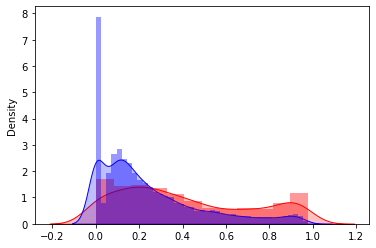

In [10]:
# Benchmark SPPIDER
   
all_pred = []
all_labels = []

all_pred_res = []
all_labels_res = []

all_roc_auc_per_prot_sppider = []
all_res_roc_auc_per_prot_sppider = []

for fn in os.listdir(sppider_pred_dir):  
    pdbid_chain = fn.split('.')[0]
    pdbid = pdbid_chain.split('_')[0]
    print(pdbid)
    
    if pdbid not in transient_pdbs: 
        continue

    l, p, res_l, res_p, roc_auc, res_roc_auc = compute_roc_auc_sppider_intpred_psiver(sppider_pred_dir, pdbid_chain)

    all_pred.append(p)
    all_labels.append(l)
    
    all_pred_res.append(res_p)
    all_labels_res.append(res_l)
    
    all_roc_auc_per_prot_sppider.append(roc_auc)
    all_res_roc_auc_per_prot_sppider.append(res_roc_auc)
    
print("Number of proteins: {}".format(len(all_pred)))

all_pred = np.concatenate(all_pred, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

all_pred_by_point_sppider = all_pred.copy()
all_labels_by_point_sppider = all_labels.copy()

#print(metrics.roc_auc_score(all_my_labels_per_res, all_my_pred_per_res))

all_labels_res = np.concatenate(all_labels_res, axis=0)

all_pred_res = np.concatenate(all_pred_res, axis=0)


all_roc_auc = sklearn.metrics.roc_auc_score(all_labels, all_pred)
all_roc_auc_res = sklearn.metrics.roc_auc_score(all_labels_res, all_pred_res)



print('Global ROC AUC: {:.2f}'.format(all_roc_auc))
print('Global ROC AUC per residue: {:.2f}'.format(all_roc_auc_res))

print('Median ROC AUC per protein : {:.2f}'.format(np.median(all_roc_auc_per_prot_sppider)))
print('Median ROC AUC per residue per protein: {:.2f}'.format(np.median(all_res_roc_auc_per_prot_sppider)))

pos_label = np.where(all_labels_res == 1)[0]
pos = all_pred_res[pos_label]
neg_label = np.where(all_labels_res == 0)[0]
neg = all_pred_res[neg_label]
sns.distplot(pos, hist=True, color='r', kde_kws={"shade": True}, norm_hist=True)
sns.distplot(neg, hist=True, color='b', kde_kws={"shade": True}, norm_hist=True)

1XQS
Per residue ROC AUC: 0.89
../pdbs_benchmark/ Per point ROC AUC 1XQS_A : 0.89
1JTD
Per residue ROC AUC: 0.96
../pdbs_benchmark/ Per point ROC AUC 1JTD_B : 0.93
5TIH
Per residue ROC AUC: 0.29
../pdbs_benchmark/ Per point ROC AUC 5TIH_A : 0.27
4XL5


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2047
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2048
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1934
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1935
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2716
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.97
../pdbs_benchmark/ Per point ROC AUC 4XL5_C : 0.95
3ZWL
Per residue ROC AUC: 0.73
../pdbs_benchmark/ Per point ROC AUC 3ZWL_B : 0.69
3MCA


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2684
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2685
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2745
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2746
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3053
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.77
../pdbs_benchmark/ Per point ROC AUC 3MCA_B : 0.77
3NVN
Per residue ROC AUC: 0.93
../pdbs_benchmark/ Per point ROC AUC 3NVN_A : 0.91
4ZGY
Per residue ROC AUC: 0.85
../pdbs_benchmark/ Per point ROC AUC 4ZGY_A : 0.83
1W1W


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2971
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2972
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2628
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2629
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2994
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.86
../pdbs_benchmark/ Per point ROC AUC 1W1W_B : 0.82
4ETP
Per residue ROC AUC: 0.97
../pdbs_benchmark/ Per point ROC AUC 4ETP_A : 0.94
2C0L


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2281
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2282
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2494
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2495
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2850
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.70
../pdbs_benchmark/ Per point ROC AUC 2C0L_A : 0.73
4M0W
Per residue ROC AUC: 0.75
../pdbs_benchmark/ Per point ROC AUC 4M0W_A : 0.70
2QXV
Per residue ROC AUC: 0.69
../pdbs_benchmark/ Per point ROC AUC 2QXV_A : 0.70
1WDW


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2978
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2979
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2413
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2414
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2879
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.85
../pdbs_benchmark/ Per point ROC AUC 1WDW_H : 0.80
4YC7
Per residue ROC AUC: 0.80
../pdbs_benchmark/ Per point ROC AUC 4YC7_B : 0.84
3VYR
Per residue ROC AUC: 0.92
../pdbs_benchmark/ Per point ROC AUC 3VYR_B : 0.91
3VV2


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2328
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2329
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2262
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2263
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2206
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.80
../pdbs_benchmark/ Per point ROC AUC 3VV2_A : 0.77
3O5T
Per residue ROC AUC: 0.87
../pdbs_benchmark/ Per point ROC AUC 3O5T_A : 0.86
4C9B
Per residue ROC AUC: 0.71
../pdbs_benchmark/ Per point ROC AUC 4C9B_B : 0.65
1ZHH


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2776
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2777
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1845
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1846
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2592
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.90
../pdbs_benchmark/ Per point ROC AUC 1ZHH_A : 0.87
2XWT
Per residue ROC AUC: 0.93
../pdbs_benchmark/ Per point ROC AUC 2XWT_C : 0.93

2PMS
Per residue ROC AUC: 0.81
../pdbs_benchmark/ Per point ROC AUC 2PMS_A : 0.74
3WN7
Per residue ROC AUC: 0.86
../pdbs_benchmark/ Per point ROC AUC 3WN7_A : 0.80
1NCA


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3076
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3077
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2968
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2969
  PDBConstructionWarning,


Per residue ROC AUC: 0.50
../pdbs_benchmark/ Per point ROC AUC 1NCA_N : 0.46
3FHC
Per residue ROC AUC: 0.52
../pdbs_benchmark/ Per point ROC AUC 3FHC_A : 0.53
2V9T
Per residue ROC AUC: 0.94
../pdbs_benchmark/ Per point ROC AUC 2V9T_B : 0.94
4ZRJ


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1642
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 1643
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2452
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2453
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2352
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.88
../pdbs_benchmark/ Per point ROC AUC 4ZRJ_A : 0.86
4ETP
Per residue ROC AUC: 0.98
../pdbs_benchmark/ Per point ROC AUC 4ETP_B : 0.94
4V0O
Per residue ROC AUC: 0.75
../pdbs_benchmark/ Per point ROC AUC 4V0O_F : 0.73
2F4M


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2231
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2232
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2449
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2450
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2501
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.99
../pdbs_benchmark/ Per point ROC AUC 2F4M_A : 0.97
2WUS
Per residue ROC AUC: 0.52
../pdbs_benchmark/ Per point ROC AUC 2WUS_A : 0.47
2V3B
Per residue ROC AUC: 0.95
../pdbs_benchmark/ Per point ROC AUC 2V3B_A : 0.91
4HDO


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2825
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2826
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2539
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2540
  PDBConstructionWarning,


Per residue ROC AUC: 0.86
../pdbs_benchmark/ Per point ROC AUC 4HDO_A : 0.84
3BH6
Per residue ROC AUC: 0.77
../pdbs_benchmark/ Per point ROC AUC 3BH6_B : 0.72
2I3T
Per residue ROC AUC: 0.85
../pdbs_benchmark/ Per point ROC AUC 2I3T_A : 0.80
4BKX


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2468
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2469
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2646
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2647
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2965
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.71
../pdbs_benchmark/ Per point ROC AUC 4BKX_B : 0.69
2AYO
Per residue ROC AUC: 0.72
../pdbs_benchmark/ Per point ROC AUC 2AYO_A : 0.70
1XG2
Per residue ROC AUC: 0.47
../pdbs_benchmark/ Per point ROC AUC 1XG2_A : 0.43
4Y61


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2811
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2812
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2433
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2434
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1888
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.79
../pdbs_benchmark/ Per point ROC AUC 4Y61_B : 0.70
5J57
Per residue ROC AUC: 0.52
../pdbs_benchmark/ Per point ROC AUC 5J57_A : 0.50
4X33
Per residue ROC AUC: 0.96
../pdbs_benchmark/ Per point ROC AUC 4X33_B : 0.93
3SJA


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2088
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2089
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2501
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2502
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2648
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.23
../pdbs_benchmark/ Per point ROC AUC 3SJA_I : 0.15
3QML
Per residue ROC AUC: 0.50
../pdbs_benchmark/ Per point ROC AUC 3QML_D : 0.43
1I2M
Per residue ROC AUC: 0.91
../pdbs_benchmark/ Per point ROC AUC 1I2M_B : 0.87
3H6G


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2247
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2248
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2900
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2901
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3052
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Per residue ROC AUC: 0.98
../pdbs_benchmark/ Per point ROC AUC 3H6G_B : 0.96
1EWY
Per residue ROC AUC: 0.86
../pdbs_benchmark/ Per point ROC AUC 1EWY_A : 0.82
4DVG
Per residue ROC AUC: 0.91


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2387
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2388
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2372
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2373
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2164
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

../pdbs_benchmark/ Per point ROC AUC 4DVG_B : 0.88
4YEB
Per residue ROC AUC: 0.60
../pdbs_benchmark/ Per point ROC AUC 4YEB_A : 0.59
1F6M
Per residue ROC AUC: 0.92
../pdbs_benchmark/ Per point ROC AUC 1F6M_A : 0.89
4LVN
Per residue ROC AUC: 0.88


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2424
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2425
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2630
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2631
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 2553
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

../pdbs_benchmark/ Per point ROC AUC 4LVN_A : 0.86
3RT0
Per residue ROC AUC: 0.59
../pdbs_benchmark/ Per point ROC AUC 3RT0_A : 0.64
Number of proteins: 51
Global ROC AUC: 0.77
Global ROC AUC per residue: 0.79
Median ROC AUC per protein : 0.80
Median ROC AUC per residue per protein: 0.85


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

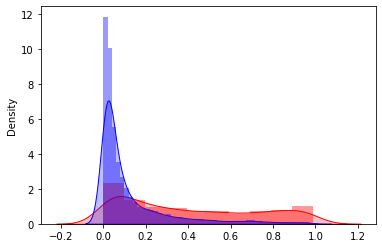

In [11]:
# Benchmark AToNN
   
all_pred = []
all_labels = []

all_pred_res = []
all_labels_res = []

all_roc_auc_per_prot_atonn = []
all_res_roc_auc_per_prot_atonn = []

for fn in os.listdir(atonn_pred_dir):  
    pdbid_chain = fn.split('.')[0]
    pdbid = pdbid_chain.split('_')[0]
    print(pdbid)
    
    if pdbid not in transient_pdbs: 
        continue

    l, p, res_l, res_p, roc_auc, res_roc_auc = compute_roc_auc_sppider_intpred_psiver(atonn_pred_dir, pdbid_chain, alpha=1.0)

    all_pred.append(p)
    all_labels.append(l)
    
    all_pred_res.append(res_p)
    all_labels_res.append(res_l)
    
    all_roc_auc_per_prot_atonn.append(roc_auc)
    all_res_roc_auc_per_prot_atonn.append(res_roc_auc)
    
print("Number of proteins: {}".format(len(all_pred)))

all_pred = np.concatenate(all_pred, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

all_pred_by_point_atonn = all_pred.copy()
all_labels_by_point_atonn = all_labels.copy()

#print(metrics.roc_auc_score(all_my_labels_per_res, all_my_pred_per_res))

all_labels_res = np.concatenate(all_labels_res, axis=0)

all_pred_res = np.concatenate(all_pred_res, axis=0)


all_roc_auc = sklearn.metrics.roc_auc_score(all_labels, all_pred)
all_roc_auc_res = sklearn.metrics.roc_auc_score(all_labels_res, all_pred_res)



print('Global ROC AUC: {:.2f}'.format(all_roc_auc))
print('Global ROC AUC per residue: {:.2f}'.format(all_roc_auc_res))

print('Median ROC AUC per protein : {:.2f}'.format(np.median(all_roc_auc_per_prot_atonn)))
print('Median ROC AUC per residue per protein: {:.2f}'.format(np.median(all_res_roc_auc_per_prot_atonn)))

pos_label = np.where(all_labels_res == 1)[0]
pos = all_pred_res[pos_label]
neg_label = np.where(all_labels_res == 0)[0]
neg = all_pred_res[neg_label]
sns.distplot(pos, hist=True, color='r', kde_kws={"shade": True}, norm_hist=True)
sns.distplot(neg, hist=True, color='b', kde_kws={"shade": True}, norm_hist=True)

In [12]:
# Compute the MASIF predictions per residue.
# Params: myid: PDBID_CHAIN format
# scores: the predicted scores for this one. 
def compute_pred_labels_per_residue(myid, scores):
    # We use the same pdb that sppider predicted. 
    parser = PDBParser()
    # Use the same pdb that sppider used. 
    struct = parser.get_structure(sppider_pred_dir+myid+'.pdb',sppider_pred_dir+myid+'.pdb')
    atoms = Selection.unfold_entities(struct, 'A')
    residues = Selection.unfold_entities(struct, 'R')
    
    ground_truth_mesh = pymesh.load_mesh(ground_truth_dir+myid+'.ply')
    
    res_labels = assign_labels_per_residue(atoms, residues, ground_truth_mesh)
    
    # Now assign predictions to each vert    
    verts = ground_truth_mesh.vertices
    ground_truth_mesh.add_attribute("vertex_area")
    vertex_areas = ground_truth_mesh.get_attribute("vertex_area")
    
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    verts = ground_truth_mesh.vertices.astype(float)
    
    
    residues = [x for x in verts]
    flann = pyflann.FLANN()
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n= len(r)
    
    # For each residue, assign the mean score. 
    res_scores = {}
    res_areas = {}
    for ix, v in enumerate(verts): 
        pred = scores[ix]
        res_id = atoms[r[ix]].get_parent().get_id()
        if res_id not in res_scores:
            res_scores[res_id] = []
            res_areas[res_id] = []
        res_scores[res_id].append(pred)
        res_areas[res_id].append(pred)
    print('Total number of residues {}'.format(len(res_scores.keys())))

    for key in res_scores:
        res_scores[key] =  np.max(res_scores[key])

    pred_per_res = []
    labels_per_res = []
    for key in res_labels: 
        if key in res_scores and key in res_labels:
            pred_per_res.append(res_scores[key])
            labels_per_res.append(res_labels[key])
    
    return pred_per_res, labels_per_res 

In [20]:
# Compute per residue and per point ROC AUC scores for MASIF> 
def compute_masif_scores():
    all_my_scores = []
    all_my_labels = []
    all_my_auc_per_protein = {}
    all_my_auc_per_res = []
    all_my_names = []
    all_pred_per_res = {}
    
    all_my_pred_per_res = []
    all_my_labels_per_res = []
    count = 0

    for name in os.listdir(masif_pred_dir): 

        myid = name.split('.')[0]
        pdbid = myid.split('_')[0]
        print(pdbid)
    
        if pdbid not in transient_pdbs: 
            continue
        # Load interface for file. 
        mesh = pymesh.load_mesh(masif_pred_dir+'/'+name)
        masif_pred = mesh.get_attribute('vertex_iface')
        all_my_scores.append(masif_pred)
        
        # Load groundtruth for file. 
        mesh = pymesh.load_mesh(ground_truth_dir+'/'+name)
        groundtruth = mesh.get_attribute('vertex_iface')
        all_my_labels.append(groundtruth)
        
        auc = metrics.roc_auc_score(groundtruth, masif_pred)
        print (auc)
        all_my_auc_per_protein[myid] = auc

        count = count+1
            
        print('{} ROC AUC: {}'.format(myid, auc))
            
        # Compute the prediction per residue.
        pred_per_res, labels_per_res = compute_pred_labels_per_residue(myid, masif_pred)
        all_pred_per_res[myid] = pred_per_res
        auc_per_res = metrics.roc_auc_score(labels_per_res, pred_per_res)
        all_my_auc_per_res.append(auc_per_res)

        all_my_pred_per_res.append(pred_per_res)
        all_my_labels_per_res.append(labels_per_res)
        print('{} ROC AUC per res: {}'.format(myid, auc_per_res))

    all_my_scores = np.concatenate(all_my_scores, axis=0)
    all_my_labels = np.concatenate(all_my_labels, axis=0)
    print('Number of proteins: {}'.format(count))
    print('Median AUC per res: {}'.format(np.median(all_my_auc_per_res)))
            
    return all_my_scores, all_my_labels, all_my_auc_per_protein, \
                    all_my_names, \
                    all_my_labels_per_res, all_my_pred_per_res, \
                    all_my_auc_per_res, \
                    all_pred_per_res

In [21]:
from sklearn import metrics
import os

all_scores_masif, all_labels_masif, all_auc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_auc_per_protein_per_res_masif, _ = compute_masif_scores()

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    

print('ROC AUC for all points : {:.3f}'.format(metrics.roc_auc_score(all_labels_masif, all_scores_masif)))
print('ROC AUC for all residues: {:.3f}'.format(metrics.roc_auc_score(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median AUC per protein at the residue level: {:.3f}'.format(np.median(all_auc_per_protein_per_res_masif)))

all_auc_per_protein_masif_list = [all_auc_per_protein_masif[x] for x in all_auc_per_protein_masif.keys() ]
print(np.median(all_auc_per_protein_masif_list))

print('Median AUC per protein at the point level: {:.3f}'.format(np.median(all_auc_per_protein_masif_list)))

4ETP
0.9325052852950115
4ETP_B ROC AUC: 0.9325052852950115
Total number of residues 253
4ETP_B ROC AUC per res: 0.9349779735682819
3SJA
0.23343990330419095
3SJA_I ROC AUC: 0.23343990330419095


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4718
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4719
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5292
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5293
  PDBConstructionWarning,


Total number of residues 310
3SJA_I ROC AUC per res: 0.19572368421052633
3MCA
0.8610093830060467
3MCA_B ROC AUC: 0.8610093830060467


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5474
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5475
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4291
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4292
  PDBConstructionWarning,


Total number of residues 307
3MCA_B ROC AUC per res: 0.7594521604938271
2MTA
2OOR
3WN7
0.7291930553444462
3WN7_A ROC AUC: 0.7291930553444462
Total number of residues 247
3WN7_A ROC AUC per res: 0.6195084485407066
4C9B
0.532132486967701
4C9B_B ROC AUC: 0.532132486967701


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4488
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4489
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5482
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5483
  PDBConstructionWarning,


Total number of residues 232
4C9B_B ROC AUC per res: 0.4545608968914558
1ZHH
0.7383194850112892
1ZHH_A ROC AUC: 0.7383194850112892
Total number of residues 286
1ZHH_A ROC AUC per res: 0.6523985239852399
3H6G
0.9412925799563508
3H6G_B ROC AUC: 0.9412925799563508


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6088
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6089
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6030
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6031
  PDBConstructionWarning,


Total number of residues 305
3H6G_B ROC AUC per res: 0.9649725274725274
4ETP
0.9569008182323422
4ETP_A ROC AUC: 0.9569008182323422
Total number of residues 327
4ETP_A ROC AUC per res: 0.9584328714763497
2PMS
0.8302527402669955
2PMS_A ROC AUC: 0.8302527402669955
Total number of residues 279
2PMS_A ROC AUC per res: 0.798140770252324
4YC7
0.743368099170046
4YC7_B ROC AUC: 0.743368099170046


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5140
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5141
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4842
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4843
  PDBConstructionWarning,


Total number of residues 245
4YC7_B ROC AUC per res: 0.6987218502738892
5TIH
0.25242319246692924
5TIH_A ROC AUC: 0.25242319246692924


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5341
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5342
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4763
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4764
  PDBConstructionWarning,


Total number of residues 282
5TIH_A ROC AUC per res: 0.23707706766917294
4DVG
0.762499970064971
4DVG_B ROC AUC: 0.762499970064971
Total number of residues 276
4DVG_B ROC AUC per res: 0.7054865424430641
1GP2
3NVN
0.865961738949481
3NVN_A ROC AUC: 0.865961738949481


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6061
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6062
  PDBConstructionWarning,


Total number of residues 338
3NVN_A ROC AUC per res: 0.8194978926149898
3FHC
0.41368560905796037
3FHC_A ROC AUC: 0.41368560905796037


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5956
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5957
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4854
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4855
  PDBConstructionWarning,


Total number of residues 326
3FHC_A ROC AUC per res: 0.4005572971090212
4ZRJ
0.9290031805481243
4ZRJ_A ROC AUC: 0.9290031805481243
Total number of residues 261
4ZRJ_A ROC AUC per res: 0.9121951219512194
3BH6
0.8637100744471169
3BH6_B ROC AUC: 0.8637100744471169


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4894
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4895
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5102
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5103
  PDBConstructionWarning,


Total number of residues 263
3BH6_B ROC AUC per res: 0.8550210970464135
3RT0
0.63753981838064
3RT0_A ROC AUC: 0.63753981838064
Total number of residues 263
3RT0_A ROC AUC per res: 0.5542635658914729
2V9T
0.9448898107337309
2V9T_B ROC AUC: 0.9448898107337309


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3329
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3330
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4230
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4231
  PDBConstructionWarning,


Total number of residues 179
2V9T_B ROC AUC per res: 0.9196428571428571
4YEB
0.30842007374672264
4YEB_A ROC AUC: 0.30842007374672264
Total number of residues 205
4YEB_A ROC AUC per res: 0.3280701754385964
3VV2
0.7720700157350882
3VV2_A ROC AUC: 0.7720700157350882
Total number of residues 228
3VV2_A ROC AUC per res: 0.6926477812346488
3BP8
1XQS
0.8668554287697527
1XQS_A ROC AUC: 0.8668554287697527
Total number of residues 217
1XQS_A ROC AUC per res: 0.868302312464749
3QML


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4592
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4593
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4115
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4116
  PDBConstructionWarning,


0.656069492653465
3QML_D ROC AUC: 0.656069492653465
Total number of residues 232
3QML_D ROC AUC per res: 0.6210628019323672
2I3T
0.8429039439739575
2I3T_A ROC AUC: 0.8429039439739575


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4498
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4499
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5295
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5296
  PDBConstructionWarning,


Total number of residues 282
2I3T_A ROC AUC per res: 0.7835648148148148
3VYR
0.891829367647864
3VYR_B ROC AUC: 0.891829367647864


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5755
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5756
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5754
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5755
  PDBConstructionWarning,


Total number of residues 297
3VYR_B ROC AUC per res: 0.9076286764705883
1I2M
0.705224134429956
1I2M_B ROC AUC: 0.705224134429956
Total number of residues 311
1I2M_B ROC AUC per res: 0.6869292626414065
2F4M
0.936316576658875
2F4M_A ROC AUC: 0.936316576658875


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4859
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4860
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4950
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4951
  PDBConstructionWarning,


Total number of residues 259
2F4M_A ROC AUC per res: 0.9556851311953354
4M0W
0.8937126928750877
4M0W_A ROC AUC: 0.8937126928750877
Total number of residues 272
4M0W_A ROC AUC per res: 0.8685175484546883
4XL5
0.9480246716989467
4XL5_C ROC AUC: 0.9480246716989467


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3796
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3797
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4153
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4154
  PDBConstructionWarning,


Total number of residues 206
4XL5_C ROC AUC per res: 0.9300673148840688
5J57
0.29827168476651966
5J57_A ROC AUC: 0.29827168476651966
Total number of residues 225
5J57_A ROC AUC per res: 0.3258998435054773
1EWY
0.7542497591856523
1EWY_A ROC AUC: 0.7542497591856523


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4756
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4757
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4817
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4818
  PDBConstructionWarning,


Total number of residues 260
1EWY_A ROC AUC per res: 0.8324637681159421
1F6M
0.8256860771353656
1F6M_A ROC AUC: 0.8256860771353656
Total number of residues 280
1F6M_A ROC AUC per res: 0.8276923076923077
4V0O
0.850999751734946
4V0O_F ROC AUC: 0.850999751734946


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4389
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4390
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5588
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5589
  PDBConstructionWarning,


Total number of residues 270
4V0O_F ROC AUC per res: 0.8728005865102639
2AYO
0.871198177086431
2AYO_A ROC AUC: 0.871198177086431
Total number of residues 310
2AYO_A ROC AUC per res: 0.8071296296296296
4BKX
0.7848349612058485
4BKX_B ROC AUC: 0.7848349612058485
Total number of residues 266
4BKX_B ROC AUC per res: 0.7552778974579922
3LVK
3O5T
0.8389708668613335
3O5T_A ROC AUC: 0.8389708668613335


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5813
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5814
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4494
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4495
  PDBConstructionWarning,


Total number of residues 220
3O5T_A ROC AUC per res: 0.7803392779469334
3ZWL
0.7810445204717154
3ZWL_B ROC AUC: 0.7810445204717154
Total number of residues 290
3ZWL_B ROC AUC per res: 0.7411140583554376
2QXV
0.8590961176367113
2QXV_A ROC AUC: 0.8590961176367113


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5280
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5281
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5624
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5625
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4550
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/

Total number of residues 283
2QXV_A ROC AUC per res: 0.8751993620414673
2C0L
0.6976427210560338
2C0L_A ROC AUC: 0.6976427210560338
Total number of residues 249
2C0L_A ROC AUC per res: 0.6146428571428572
4HDO
0.7855665998869883
4HDO_A ROC AUC: 0.7855665998869883


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5131
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5132
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5206
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5207
  PDBConstructionWarning,


Total number of residues 282
4HDO_A ROC AUC per res: 0.7309627641730962
4LVN
0.8935504560164755
4LVN_A ROC AUC: 0.8935504560164755
Total number of residues 245
4LVN_A ROC AUC per res: 0.9177272727272727
1JTD
0.9281327325620278
1JTD_B ROC AUC: 0.9281327325620278


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3794
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3795
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3695
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3696
  PDBConstructionWarning,


Total number of residues 237
1JTD_B ROC AUC per res: 0.9701940035273369
2XWT
0.9399650020191143
2XWT_C ROC AUC: 0.9399650020191143
Total number of residues 193
2XWT_C ROC AUC per res: 0.9454545454545454
2WUS
0.8458786638253328
2WUS_A ROC AUC: 0.8458786638253328


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5155
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5156
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5291
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5292
  PDBConstructionWarning,


Total number of residues 274
2WUS_A ROC AUC per res: 0.8467432950191571
1W1W
0.8232751674152109
1W1W_B ROC AUC: 0.8232751674152109
Total number of residues 283
1W1W_B ROC AUC per res: 0.8233351678591084
4ZGY
0.8519036885346533
4ZGY_A ROC AUC: 0.8519036885346533


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5923
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5924
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4839
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4840
  PDBConstructionWarning,


Total number of residues 328
4ZGY_A ROC AUC per res: 0.8032786885245901
1XG2
0.7721965497926699
1XG2_A ROC AUC: 0.7721965497926699
Total number of residues 244
1XG2_A ROC AUC per res: 0.7502741228070176
4X33
0.9098260710844206
4X33_B ROC AUC: 0.9098260710844206


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4913
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4914
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5990
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5991
  PDBConstructionWarning,


Total number of residues 285
4X33_B ROC AUC per res: 0.9260377358490566
1WDW
0.8077133203299502
1WDW_H ROC AUC: 0.8077133203299502
Total number of residues 302
1WDW_H ROC AUC per res: 0.8440779610194902
1NCA
0.6073050323050323
1NCA_N ROC AUC: 0.6073050323050323


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5994
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5995
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5703
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5704
  PDBConstructionWarning,


Total number of residues 289
1NCA_N ROC AUC per res: 0.5604756047560475
3R9A
2V3B
0.9304992977868178
2V3B_A ROC AUC: 0.9304992977868178
Total number of residues 336
2V3B_A ROC AUC per res: 0.9662538699690403
4Y61
0.7199084334989589
4Y61_B ROC AUC: 0.7199084334989589
Total number of residues 204
4Y61_B ROC AUC per res: 0.6750550487574709
Number of proteins: 51
Median AUC per res: 0.8032786885245901
ROC AUC for all points : 0.785
ROC AUC for all residues: 0.759
Median AUC per protein at the residue level: 0.803
0.8302527402669955
Median AUC per protein at the point level: 0.830


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3814
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3815
  PDBConstructionWarning,


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later


[0.8509683318094922, 0.8032786885245901, 0.6483566646378576, 0.6106346483704974]


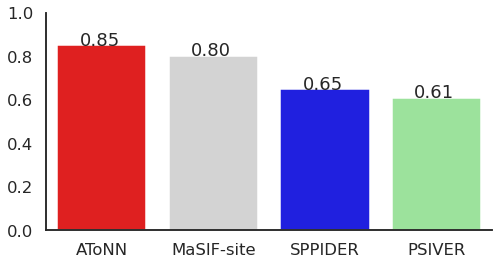

In [22]:
import seaborn as sns
sns.set(style="white", context="talk")

xdata = ['AToNN', 'MaSIF-site', 'SPPIDER', 'PSIVER']
ydata = [np.median(all_res_roc_auc_per_prot_atonn),
         np.median(all_auc_per_protein_per_res_masif),
         np.median(all_res_roc_auc_per_prot_sppider), 
         np.median(all_res_roc_auc_per_prot_psiver)]

f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=False)

plt.ylim([0.5,1.0])

sns.barplot(x=xdata, y=ydata, ax=ax1, palette=['red', 'lightgray', 'blue', 'lightgreen', 'pink'])

ax1.set_ylim([0,1])
plt.text(-0.2,ydata[0],'{:.2f}'.format(ydata[0]))
plt.text(0.8,ydata[1],'{:.2f}'.format(ydata[1]))
plt.text(1.8,ydata[2],'{:.2f}'.format(ydata[2]))
plt.text(2.8,ydata[3],'{:.2f}'.format(ydata[3]))
#ax1.set_xticks([])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#axes[0].spines['right'].set_visible(False)
#axes[0].spines['top'].set_visible(False)


print(ydata)

plt.savefig('sppider_bars_w_intpred.pdf', type='pdf')

In [23]:
# Compute the MASIF predictions per residue.
# Params: myid: PDBID_CHAIN format
# scores: the predicted scores for this one. 
def compute_pred_labels_per_residue(myid, scores):
    # We use the same pdb that sppider predicted. 
    parser = PDBParser()
    # Use the same pdb that sppider used. 
    struct = parser.get_structure(sppider_pred_dir+myid+'.pdb',sppider_pred_dir+myid+'.pdb')
    atoms = Selection.unfold_entities(struct, 'A')
    residues = Selection.unfold_entities(struct, 'R')
    
    ground_truth_mesh = pymesh.load_mesh(ground_truth_dir+myid+'.ply')
    
    res_labels = assign_labels_per_residue(atoms, residues, ground_truth_mesh)
    
    # Now assign predictions to each vert    
    verts = ground_truth_mesh.vertices
    ground_truth_mesh.add_attribute("vertex_area")
    vertex_areas = ground_truth_mesh.get_attribute("vertex_area")
    
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    verts = ground_truth_mesh.vertices.astype(float)
    
    
    residues = [x for x in verts]
    flann = pyflann.FLANN()
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n= len(r)
    
    # For each residue, assign the mean score. 
    res_scores = {}
    res_areas = {}
    for ix, v in enumerate(verts): 
        pred = scores[ix]
        res_id = atoms[r[ix]].get_parent().get_id()
        if res_id not in res_scores:
            res_scores[res_id] = []
            res_areas[res_id] = []
        res_scores[res_id].append(pred)
        res_areas[res_id].append(pred)
    print('Total number of residues {}'.format(len(res_scores.keys())))

    for key in res_scores:
        res_scores[key] =  np.max(res_scores[key])
        
    pred_per_res = []
    labels_per_res = []
    for r in Selection.unfold_entities(struct, 'R'):
        i = r.get_id()
        if i in res_scores:
            pred_per_res.append(res_scores[i])
        else:
            pred_per_res.append(0.0)
            
        if i in res_labels:
            labels_per_res.append(res_labels[i])
        else:
            labels_per_res.append(0.0)
    
    return pred_per_res, labels_per_res 

    pred_per_res = []
    labels_per_res = []
    for key in res_labels: 
        if key in res_scores and key in res_labels:
            pred_per_res.append(res_scores[key])
            labels_per_res.append(res_labels[key])
    
    return pred_per_res, labels_per_res 

In [24]:
# Compute per residue and per point ROC AUC scores for MASIF> 
def compute_masif_scores():
    all_my_scores = []
    all_my_labels = []
    all_my_auc_per_protein = {}
    all_my_auc_per_res = []
    all_my_names = []
    all_pred_per_res = {}
    
    all_my_pred_per_res = []
    all_my_labels_per_res = []
    count = 0

    for name in os.listdir(masif_pred_dir): 

        myid = name.split('.')[0]
        pdbid = myid.split('_')[0]
        print(pdbid)
    
        if pdbid not in transient_pdbs: 
            continue
        # Load interface for file. 
        mesh = pymesh.load_mesh(masif_pred_dir+'/'+name)
        masif_pred = mesh.get_attribute('vertex_iface')
        all_my_scores.append(masif_pred)
        
        # Load groundtruth for file. 
        mesh = pymesh.load_mesh(ground_truth_dir+'/'+name)
        groundtruth = mesh.get_attribute('vertex_iface')
        all_my_labels.append(groundtruth)
        
        auc = metrics.roc_auc_score(groundtruth, masif_pred)
        print (auc)
        all_my_auc_per_protein[myid] = auc

        count = count+1
            
        print('{} ROC AUC: {}'.format(myid, auc))
            
        # Compute the prediction per residue.
        pred_per_res, labels_per_res = compute_pred_labels_per_residue(myid, masif_pred)
        all_pred_per_res[myid] = pred_per_res
        auc_per_res = metrics.roc_auc_score(labels_per_res, pred_per_res)
        all_my_auc_per_res.append(auc_per_res)

        all_my_pred_per_res.append(pred_per_res)
        all_my_labels_per_res.append(labels_per_res)
        print('{} ROC AUC per res: {}'.format(myid, auc_per_res))

    all_my_scores = np.concatenate(all_my_scores, axis=0)
    all_my_labels = np.concatenate(all_my_labels, axis=0)
    print('Number of proteins: {}'.format(count))
    print('Median AUC per res: {}'.format(np.median(all_my_auc_per_res)))
            
    return all_my_scores, all_my_labels, all_my_auc_per_protein, \
                    all_my_names, \
                    all_my_labels_per_res, all_my_pred_per_res, \
                    all_my_auc_per_res, \
                    all_pred_per_res

In [25]:
import json
from sklearn import metrics
import os

all_scores_masif, all_labels_masif, all_auc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_auc_per_protein_per_res_masif, \
    all_pred_per_res = compute_masif_scores()

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    

print('ROC AUC for all points : {:.3f}'.format(metrics.roc_auc_score(all_labels_masif, all_scores_masif)))
print('ROC AUC for all residues: {:.3f}'.format(metrics.roc_auc_score(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median AUC per protein at the residue level: {:.3f}'.format(np.median(all_auc_per_protein_per_res_masif)))

all_auc_per_protein_masif_list = [all_auc_per_protein_masif[x] for x in all_auc_per_protein_masif.keys() ]
print(np.median(all_auc_per_protein_masif_list))

print('Median AUC per protein at the point level: {:.3f}'.format(np.median(all_auc_per_protein_masif_list)))

json.dump(all_pred_per_res, open("masif_pred_per_res.json", 'w'))

4ETP
0.9325052852950115
4ETP_B ROC AUC: 0.9325052852950115
Total number of residues 252
4ETP_B ROC AUC per res: 0.9438167938931298
3SJA
0.23343990330419095
3SJA_I ROC AUC: 0.23343990330419095


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4718
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4719
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5292
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5293
  PDBConstructionWarning,


Total number of residues 310
3SJA_I ROC AUC per res: 0.26476476476476474
3MCA
0.8610093830060467
3MCA_B ROC AUC: 0.8610093830060467
Total number of residues 306
3MCA_B ROC AUC per res: 0.7856897144822842
2MTA
2OOR
3WN7
0.7291930553444462
3WN7_A ROC AUC: 0.7291930553444462


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5474
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5475
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4291
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4292
  PDBConstructionWarning,


Total number of residues 248
3WN7_A ROC AUC per res: 0.6774739583333333
4C9B
0.532132486967701
4C9B_B ROC AUC: 0.532132486967701
Total number of residues 233
4C9B_B ROC AUC per res: 0.5619621342512909
1ZHH
0.7383194850112892
1ZHH_A ROC AUC: 0.7383194850112892


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4488
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4489
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5482
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5483
  PDBConstructionWarning,


Total number of residues 285
1ZHH_A ROC AUC per res: 0.7179331306990882
3H6G
0.9412925799563508
3H6G_B ROC AUC: 0.9412925799563508
Total number of residues 305
3H6G_B ROC AUC per res: 0.9723240469208212
4ETP


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6088
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6089
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6030
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6031
  PDBConstructionWarning,


0.9569008182323422
4ETP_A ROC AUC: 0.9569008182323422
Total number of residues 328
4ETP_A ROC AUC per res: 0.964997964997965
2PMS
0.8302527402669955
2PMS_A ROC AUC: 0.8302527402669955


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5140
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5141
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4842
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4843
  PDBConstructionWarning,


Total number of residues 279
2PMS_A ROC AUC per res: 0.8338206627680311
4YC7
0.743368099170046
4YC7_B ROC AUC: 0.743368099170046
Total number of residues 244
4YC7_B ROC AUC per res: 0.7557071960297767
5TIH
0.25242319246692924
5TIH_A ROC AUC: 0.25242319246692924
Total number of residues 282
5TIH_A ROC AUC per res: 0.34798387096774197
4DVG
0.762499970064971
4DVG_B ROC AUC: 0.762499970064971


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5341
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5342
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4763
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4764
  PDBConstructionWarning,


Total number of residues 276
4DVG_B ROC AUC per res: 0.7237285416332424
1GP2
3NVN
0.865961738949481
3NVN_A ROC AUC: 0.865961738949481
Total number of residues 340
3NVN_A ROC AUC per res: 0.8331726133076183
3FHC


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6061
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6062
  PDBConstructionWarning,


0.41368560905796037
3FHC_A ROC AUC: 0.41368560905796037
Total number of residues 327
3FHC_A ROC AUC per res: 0.49931426332288403
4ZRJ


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5956
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5957
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4854
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4855
  PDBConstructionWarning,


0.9290031805481243
4ZRJ_A ROC AUC: 0.9290031805481243
Total number of residues 261
4ZRJ_A ROC AUC per res: 0.9269230769230768
3BH6
0.8637100744471169
3BH6_B ROC AUC: 0.8637100744471169


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4894
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4895
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5102
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5103
  PDBConstructionWarning,


Total number of residues 266
3BH6_B ROC AUC per res: 0.8725259515570934
3RT0
0.63753981838064
3RT0_A ROC AUC: 0.63753981838064
Total number of residues 263
3RT0_A ROC AUC per res: 0.6610119047619047
2V9T
0.9448898107337309
2V9T_B ROC AUC: 0.9448898107337309


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3329
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3330
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4230
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4231
  PDBConstructionWarning,


Total number of residues 180
2V9T_B ROC AUC per res: 0.9329896907216495
4YEB
0.30842007374672264
4YEB_A ROC AUC: 0.30842007374672264
Total number of residues 206
4YEB_A ROC AUC per res: 0.49656084656084654
3VV2
0.7720700157350882
3VV2_A ROC AUC: 0.7720700157350882


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4592
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4593
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4115
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4116
  PDBConstructionWarning,


Total number of residues 228
3VV2_A ROC AUC per res: 0.7947315548610336
3BP8
1XQS
0.8668554287697527
1XQS_A ROC AUC: 0.8668554287697527
Total number of residues 216
1XQS_A ROC AUC per res: 0.8824919441460795
3QML
0.656069492653465
3QML_D ROC AUC: 0.656069492653465


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4498
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4499
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5295
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5296
  PDBConstructionWarning,


Total number of residues 234
3QML_D ROC AUC per res: 0.68
2I3T
0.8429039439739575
2I3T_A ROC AUC: 0.8429039439739575
Total number of residues 282
2I3T_A ROC AUC per res: 0.8237179487179487
3VYR
0.891829367647864
3VYR_B ROC AUC: 0.891829367647864


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5755
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5756
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5754
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5755
  PDBConstructionWarning,


Total number of residues 297
3VYR_B ROC AUC per res: 0.9271676300578034
1I2M
0.705224134429956
1I2M_B ROC AUC: 0.705224134429956
Total number of residues 311
1I2M_B ROC AUC per res: 0.7543329623151535
2F4M
0.936316576658875
2F4M_A ROC AUC: 0.936316576658875


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4859
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4860
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4950
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4951
  PDBConstructionWarning,


Total number of residues 259
2F4M_A ROC AUC per res: 0.9611082867310625
4M0W
0.8937126928750877
4M0W_A ROC AUC: 0.8937126928750877
Total number of residues 272
4M0W_A ROC AUC per res: 0.8926353149955634
4XL5
0.9480246716989467
4XL5_C ROC AUC: 0.9480246716989467


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3796
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3797
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4153
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4154
  PDBConstructionWarning,


Total number of residues 207
4XL5_C ROC AUC per res: 0.9400123685837972
5J57
0.29827168476651966
5J57_A ROC AUC: 0.29827168476651966
Total number of residues 225
5J57_A ROC AUC per res: 0.4295634920634921
1EWY
0.7542497591856523
1EWY_A ROC AUC: 0.7542497591856523


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4756
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4757
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4817
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4818
  PDBConstructionWarning,


Total number of residues 261
1EWY_A ROC AUC per res: 0.8566544566544566
1F6M
0.8256860771353656
1F6M_A ROC AUC: 0.8256860771353656
Total number of residues 280
1F6M_A ROC AUC per res: 0.8527903469079939
4V0O
0.850999751734946
4V0O_F ROC AUC: 0.850999751734946


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4389
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4390
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5588
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5589
  PDBConstructionWarning,


Total number of residues 270
4V0O_F ROC AUC per res: 0.8964206525182136
2AYO
0.871198177086431
2AYO_A ROC AUC: 0.871198177086431
Total number of residues 308
2AYO_A ROC AUC per res: 0.8351587301587301
4BKX
0.7848349612058485
4BKX_B ROC AUC: 0.7848349612058485
Total number of residues 264
4BKX_B ROC AUC per res: 0.8340474811812392
3LVK
3O5T
0.8389708668613335
3O5T_A ROC AUC: 0.8389708668613335


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5813
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5814
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4494
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4495
  PDBConstructionWarning,


Total number of residues 221
3O5T_A ROC AUC per res: 0.8370678617157491
3ZWL
0.7810445204717154
3ZWL_B ROC AUC: 0.7810445204717154
Total number of residues 290
3ZWL_B ROC AUC per res: 0.7828698553948832
2QXV
0.8590961176367113
2QXV_A ROC AUC: 0.8590961176367113


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5280
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5281
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5624
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5625
  PDBConstructionWarning,


Total number of residues 284
2QXV_A ROC AUC per res: 0.9112602535421328
2C0L
0.6976427210560338
2C0L_A ROC AUC: 0.6976427210560338
Total number of residues 249
2C0L_A ROC AUC per res: 0.6865671641791045
4HDO
0.7855665998869883
4HDO_A ROC AUC: 0.7855665998869883


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4550
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4551
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5131
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5132
  PDBConstructionWarning,


Total number of residues 282
4HDO_A ROC AUC per res: 0.7816666666666666
4LVN
0.8935504560164755
4LVN_A ROC AUC: 0.8935504560164755
Total number of residues 245
4LVN_A ROC AUC per res: 0.9455946450809465
1JTD
0.9281327325620278
1JTD_B ROC AUC: 0.9281327325620278


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5206
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5207
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3794
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3795
  PDBConstructionWarning,


Total number of residues 237
1JTD_B ROC AUC per res: 0.9729056368732482
2XWT
0.9399650020191143
2XWT_C ROC AUC: 0.9399650020191143
Total number of residues 195
2XWT_C ROC AUC per res: 0.9507962068348541
2WUS


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3695
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3696
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5155
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5156
  PDBConstructionWarning,


0.8458786638253328
2WUS_A ROC AUC: 0.8458786638253328
Total number of residues 275
2WUS_A ROC AUC per res: 0.8753869969040248
1W1W
0.8232751674152109
1W1W_B ROC AUC: 0.8232751674152109


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5291
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5292
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5923
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5924
  PDBConstructionWarning,


Total number of residues 284
1W1W_B ROC AUC per res: 0.8495440729483282
4ZGY
0.8519036885346533
4ZGY_A ROC AUC: 0.8519036885346533
Total number of residues 328
4ZGY_A ROC AUC per res: 0.8320048309178744
1XG2
0.7721965497926699
1XG2_A ROC AUC: 0.7721965497926699
Total number of residues 244
1XG2_A ROC AUC per res: 0.811046511627907
4X33


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4839
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4840
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 4913
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4914
  PDBConstructionWarning,


0.9098260710844206
4X33_B ROC AUC: 0.9098260710844206
Total number of residues 286
4X33_B ROC AUC per res: 0.9371872303710095
1WDW
0.8077133203299502
1WDW_H ROC AUC: 0.8077133203299502


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5990
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5991
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5994
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5995
  PDBConstructionWarning,


Total number of residues 303
1WDW_H ROC AUC per res: 0.8855714547789397
1NCA
0.6073050323050323
1NCA_N ROC AUC: 0.6073050323050323
Total number of residues 289
1NCA_N ROC AUC per res: 0.6814914645103325
3R9A
2V3B
0.9304992977868178
2V3B_A ROC AUC: 0.9304992977868178
Total number of residues 335
2V3B_A ROC AUC per res: 0.9820788530465949
4Y61


/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 5703
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5704
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3814
  PDBConstructionWarning,
/home/khaos/miniconda3/envs/masif/lib/python3.6/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3815
  PDBConstructionWarning,


0.7199084334989589
4Y61_B ROC AUC: 0.7199084334989589
Total number of residues 204
4Y61_B ROC AUC per res: 0.7269293038316244
Number of proteins: 51
Median AUC per res: 0.8340474811812392
ROC AUC for all points : 0.785
ROC AUC for all residues: 0.802
Median AUC per protein at the residue level: 0.834
0.8302527402669955
Median AUC per protein at the point level: 0.830
